# State Compensator for Pitch

This document uses the model of the drag plate for the pitch motion to build the compensation signal that we want to send to the pseudo control input. 

In [19]:
# packages

%matplotlib notebook
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize, Bounds
import seaborn as sns
from numpy import sign
import matplotlib.transforms as mtransforms

## 1. Build dataframe and look at the data

In [20]:
# read the data file
filename = "model_flights/model_pitch_flight/flight_top_plate.csv"
df = pd.read_csv(filename)

# crop and get interested segment
start_log = 0.2
end_log = 0.9
n_samples = len(df.time)

df_crop = df.truncate(int(start_log*n_samples),int(end_log*n_samples))
n_samples_crop = len(df_crop.time)

print(f"New samples: {n_samples_crop}")

New samples: 29197


<IPython.core.display.Javascript object>


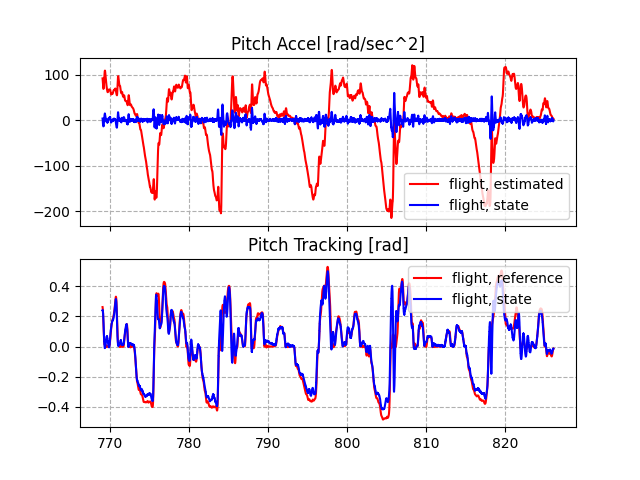

Text(0.5, 1.0, 'Pitch Tracking [rad]')

In [21]:
# plot them
f, axs = plt.subplots(2, 1, sharex=True)
t_crop = df_crop.time;

# subplot 1
axs[0].plot(t_crop,df_crop.qd_estimated_f,label="flight, estimated", color="r")
axs[0].plot(t_crop,df_crop.qd_state_f,label="flight, state", color="b")
axs[0].grid(linestyle='--')
axs[0].legend()
axs[0].set_title('Pitch Accel [rad/sec^2]')

# subplot 2
axs[1].plot(t_crop,df_crop.theta_ref,label="flight, reference", color="r")
axs[1].plot(t_crop,df_crop.theta_state,label="flight, state", color="b")
axs[1].grid(linestyle='--')
axs[1].legend()
axs[1].set_title('Pitch Tracking [rad]')

<IPython.core.display.Javascript object>


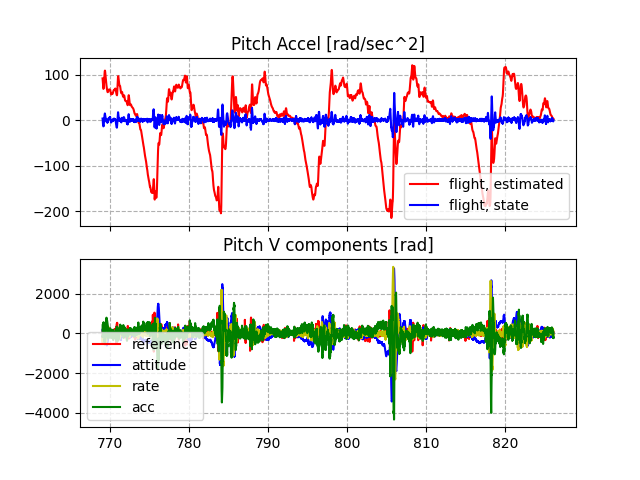

Text(0.5, 1.0, 'Pitch V components [rad]')

In [22]:
# plot them
f, axs = plt.subplots(2, 1, sharex=True)
t_crop = df_crop.time;

# get the error controller components among with the usual
qdd_ref = df_crop.qdd_ref
theta_err_comp = df_crop.theta_att_err
q_err_comp = df_crop.q_rate_err
qd_err_comp = df_crop.q_acc_err

# subplot 1
axs[0].plot(t_crop,df_crop.qd_estimated_f,label="flight, estimated", color="r")
axs[0].plot(t_crop,df_crop.qd_state_f,label="flight, state", color="b")
axs[0].grid(linestyle='--')
axs[0].legend()
axs[0].set_title('Pitch Accel [rad/sec^2]')

# subplot 2
axs[1].plot(t_crop,qdd_ref,label="reference", color="r")
axs[1].plot(t_crop,theta_err_comp,label="attitude", color="b")
axs[1].plot(t_crop,q_err_comp,label="rate", color="y")
axs[1].plot(t_crop,qd_err_comp,label="acc", color="g")
axs[1].grid(linestyle='--')
axs[1].legend()
axs[1].set_title('Pitch V components [rad]')

<IPython.core.display.Javascript object>


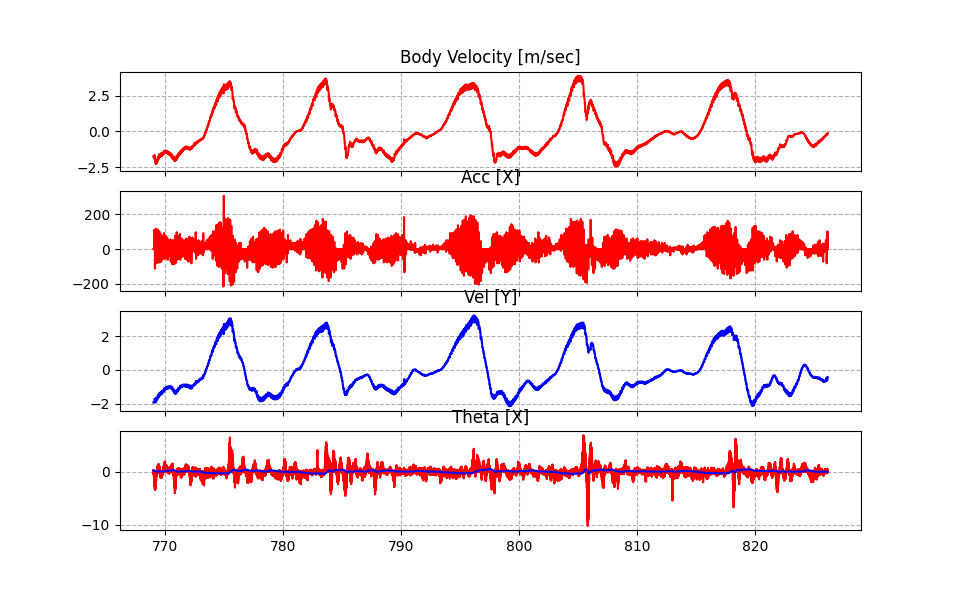

Text(0.5, 1.0, 'Theta [X]')

In [23]:
# we build the body velocity vector as we need it for the compensation

def body_velocity(x):
    
    Vx, Vy, Vz, phi, theta, psi = x[0], x[1], x[2], x[3], x[4], x[5]
    
    u = np.zeros(len(Vx))
    
    for i in range(len(Vx)):

        # rotation around roll axis
        R_phi = [[1, 0, 0],
                 [0, np.cos(phi[i]), -np.sin(phi[i])],
                 [0, np.sin(phi[i]), np.cos(phi[i])]]

        # rotation around pitch axis
        R_theta = [[np.cos(theta[i]), 0, np.sin(theta[i])],
                   [0, 1, 0],
                   [-np.sin(theta[i]), 0, np.cos(theta[i])]]

        # rotation around yaw axis
        R_psi = [[np.cos(psi[i]), -np.sin(psi[i]), 0],
                 [np.sin(psi[i]), np.cos(psi[i]), 0],
                 [0, 0, 1]]
    
        R_bg = np.linalg.multi_dot([R_psi, R_theta, R_phi])
        
        V_vect = [Vx[i], Vy[i], Vz[i]]
        
        u[i] = np.dot(np.linalg.inv(R_bg),V_vect)[0] 
    
    return u

# input signals required
states = np.zeros((6,n_samples_crop))
states[0] = df_crop.xd_state.array
states[1] = df_crop.yd_state.array
states[2] = df_crop.zd_state.array
states[3] = df_crop.phi_state.array
states[4] = df_crop.theta_state.array
states[5] = df_crop.psi_state.array

# derivatives of signal via finite difference
sf = 512
Ax = np.hstack((0,np.diff(df_crop.xd_state.array,1,axis=0)))*sf
Ay = np.hstack((0,np.diff(df_crop.yd_state.array,1,axis=0)))*sf
dtheta = np.hstack((0,np.diff(df_crop.theta_state.array,1,axis=0)))*sf

# real signals to match
u = body_velocity(states)

# plot them
f, axs = plt.subplots(4, 1, sharex=True)
t_crop = df_crop.time;

# subplot 1
axs[0].plot(t_crop,u,color="r")
axs[0].grid(linestyle='--')
axs[0].set_title('Body Velocity [m/sec]')

# subplot 2
axs[1].plot(t_crop,Ax,color="r",label="Ax")
axs[1].grid(linestyle='--')
axs[1].set_title('Acc [X]')

# subplot 3

axs[2].plot(t_crop,states[0],color="b",label="Vx")
axs[2].grid(linestyle='--')
axs[2].set_title('Vel [Y]')

# subplot 4
axs[3].plot(t_crop,dtheta,color="r",label="dtheta")
axs[3].plot(t_crop,states[4],color="b",label="theta")
axs[3].grid(linestyle='--')
axs[3].set_title('Theta [X]')

<IPython.core.display.Javascript object>


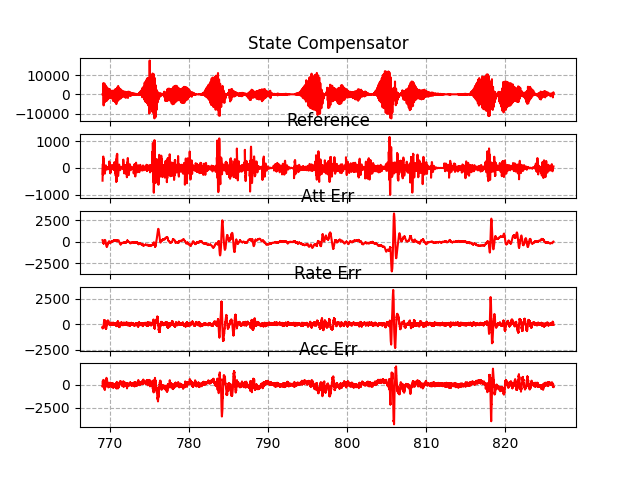

Text(0.5, 1.0, 'Acc Err')

In [30]:
# define the compensation term

def qdd_comp(Ax, Ay, Vx, Vy, theta, dtheta, u, Cd1, Cd2, Cl1, Cl2, Iyy, S_plate, l_plate, rho):
    
    return (Ax*l_plate*sign(u)*(S_plate**2*Vx*rho**2*(Cd2 + Cd1*((180*theta)/pi + 90))**2*(Vx**2 + Vy**2) + S_plate**2*Vx*rho**2*(Cl2 + Cl1*((180*theta)/pi + 90))**2*(Vx**2 + Vy**2)))/(2*Iyy*((S_plate**2*rho**2*(Cd2 + Cd1*((180*theta)/pi + 90))**2*(Vx**2 + Vy**2)**2)/4 + (S_plate**2*rho**2*(Cl2 + Cl1*((180*theta)/pi + 90))**2*(Vx**2 + Vy**2)**2)/4)**(1/2)) + (Ay*l_plate*sign(u)*(S_plate**2*Vy*rho**2*(Cd2 + Cd1*((180*theta)/pi + 90))**2*(Vx**2 + Vy**2) + S_plate**2*Vy*rho**2*(Cl2 + Cl1*((180*theta)/pi + 90))**2*(Vx**2 + Vy**2)))/(2*Iyy*((S_plate**2*rho**2*(Cd2 + Cd1*((180*theta)/pi + 90))**2*(Vx**2 + Vy**2)**2)/4 + (S_plate**2*rho**2*(Cl2 + Cl1*((180*theta)/pi + 90))**2*(Vx**2 + Vy**2)**2)/4)**(1/2)) + (dtheta*l_plate*sign(u)*((90*Cd1*S_plate**2*rho**2*(Cd2 + Cd1*((180*theta)/pi + 90))*(Vx**2 + Vy**2)**2)/pi + (90*Cl1*S_plate**2*rho**2*(Cl2 + Cl1*((180*theta)/pi + 90))*(Vx**2 + Vy**2)**2)/pi))/(2*Iyy*((S_plate**2*rho**2*(Cd2 + Cd1*((180*theta)/pi + 90))**2*(Vx**2 + Vy**2)**2)/4 + (S_plate**2*rho**2*(Cl2 + Cl1*((180*theta)/pi + 90))**2*(Vx**2 + Vy**2)**2)/4)**(1/2))

# get last optimized parameters
p0_last = [8.00000000e-04, 3.53032382e-02, 4.99999969e+00, 3.52792247e-02, 4.99998515e+00]

# define all the constants and variable needed for the term generation
Ax = np.hstack((0,np.diff(df_crop.xd_state.array,1,axis=0)))*sf
Vx = df_crop.xd_state.array
Ay = np.hstack((0,np.diff(df_crop.yd_state.array,1,axis=0)))*sf
Vy = df_crop.yd_state.array
theta = df_crop.theta_state.array
dtheta = np.hstack((0,np.diff(df_crop.theta_state.array,1,axis=0)))*sf
u = body_velocity(states)
Cd1 = p0_last[1]
Cd2 = p0_last[2]
Cl1 = p0_last[3]
Cl2 = p0_last[4]
Iyy = p0_last[0]
S_plate = 0.03
l_plate = 0.1
rho = 1.225

# build the term
qdd_comp = qdd_comp(Ax, Ay, Vx, Vy, theta, dtheta, u, Cd1, Cd2, Cl1, Cl2, Iyy, S_plate, l_plate, rho)


# plot them
f, axs = plt.subplots(5, 1, sharex=True)
t_crop = df_crop.time;

# subplot 1
axs[0].plot(t_crop,qdd_comp,color="r")
axs[0].grid(linestyle='--')
axs[0].set_title('State Compensator')

# subplot 2
axs[1].plot(t_crop,qdd_ref,color="r")
axs[1].grid(linestyle='--')
axs[1].set_title('Reference')

# subplot 3

axs[2].plot(t_crop,theta_err_comp,color="r")
axs[2].grid(linestyle='--')
axs[2].set_title('Att Err')

# subplot 4
axs[3].plot(t_crop,q_err_comp,color="r")
axs[3].grid(linestyle='--')
axs[3].set_title('Rate Err')

# subplot 5
axs[4].plot(t_crop,qd_err_comp,color="r")
axs[4].grid(linestyle='--')
axs[4].set_title('Acc Err')